In [1]:
import cv2, glob
import os, time
import time
import random
import threading
import numpy as np
from keras.models import load_model
from datetime import datetime, timedelta
from collections import deque
from roi import setting_roi
# import video_control as vc
import fnmatch
import tensorflow as tf
import math
import shutil
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
#import logging.config

In [2]:
#logging.config.fileConfig('logging.conf')
#logger = logging.getLogger('rsclassifier')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)
'''
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
tf.keras.backend.set_session(tf.Session(config=config))
'''

'\nconfig = tf.ConfigProto()\nconfig.gpu_options.per_process_gpu_memory_fraction = 0.8\ntf.keras.backend.set_session(tf.Session(config=config))\n'

In [3]:
ROI_WIDTH, ROI_HEIGHT = 150, 150
# - Change it-
model_path = r'D:\Harry\000.DataAnalysis\004.Model\cp_20201222193450.tf'
model_path = model_path.replace('\\', '/')
SAMPLING_RATIO = 100
CATEGORIES = ['건조_주간', '건조_야간','습윤_주간', '습윤_야간']
ROI = setting_roi('33C_201') # 33A_201, 33A_201_old, 33A_201_fusion, 33C_201, 33C_201_fusion, 53R_201, 53R_202  || 201 = Road, 202 = Weather

In [4]:
#
model = tf.keras.models.load_model(model_path) # Model
PREDICTION_INTERVAL = 1
PREDICTION_QUEUE_LENGTH = 20
STATUS_SENSITIVITY = 20
TODAY = datetime.today()
#SUNRISE = 50000
#SUNSET = 190000

In [5]:
# - Change it -
path = r'D:\Harry\002.Working\road\MK-SD33C\2020-11-26\201\dry_day'
path = path.replace('\\', '/')
#

# save_path2 = 'C:/Users/ThreadRipper/Desktop/dry&wet_train/color_mode_33A_data/20200910_Dry,Wet_data/day+night/other(33A_S43)_test_image/'

# subpath = f'{path}'
# subset = fnmatch.filter(os.listdir(subpath), '*.jpg')
# image_frame = []
images = glob.glob(f'{path}/*.jpg')
dd_count, dn_count, wd_count, wn_count = 0, 0, 0, 0
accruacy = []

In [17]:
for imgs in images:
    # image_frame = cv2.imread(f'{path}/CAM201_20200710001144688488_0.jpg')
    # image_frame = np.array(image_frame).reshape(-1, 1520, 2688, 3)
    # image_frame = image_frame / 255.

    is_daytime = 1
    # current_time = current_time.hour * 10000 + current_time.minute * 100 + current_time.second
    '''
    if (current_time > SUNRISE) and (current_time < SUNSET):
        is_daytime = 1
    number_of_categories = 5 if is_daytime else 2
    '''

    filedir = os.path.basename(imgs)
    filename = os.path.splitext(filedir)
    img = cv2.imread(imgs)
    roi_set = []
    for (i, j) in ROI:
        x, y = i * ROI_WIDTH, j * ROI_HEIGHT
        roi_img = img[y:y + ROI_HEIGHT, x:x + ROI_WIDTH]
        # print(roi_img)
        roi_set.append(roi_img)
        # cv2.imwrite(f'{path}/crop/{count}.jpg', roi_img)
        # count += 1

    sampling_number = min(len(roi_set), SAMPLING_RATIO)
    roi_set = random.sample(roi_set, sampling_number)
    roi_set = np.array(roi_set).reshape(-1, ROI_HEIGHT, ROI_WIDTH, 3)
    roi_set = roi_set / 255.0
    '''
    for a in range(len(roi_set)):
        cv2.imshow('asd', roi_set[a])
        cv2.waitKey(0) == 0xFF
        print(np.int64(model_day.predict(roi_set)*10))
    '''

    pred_values = model.predict(roi_set)#  if is_daytime else list(model_night.predict(roi_set))
    # print(np.int64(pred_values*10))
    preds = []
    for pred in pred_values:
        preds.append(np.argmax(pred))

    prediction_list = []
    for i in range(5):
        prediction_list.append(preds.count(i))

    
    # print('filename :', filename[0], 'pred :', preds, 'count :', prediction_list, 'class :', np.argmax(prediction_list), 'category :', CATEGORIES[np.argmax(prediction_list)])
'''
    if np.argmax(prediction_list) == 0:
        print(f'filename : {filename[0]}, count : {prediction_list}, class : {CATEGORIES[np.argmax(prediction_list)]}')
        # # print(f'filename : {filename[0]}, count : {np.int64(pred_values*10)}, class : {CATEGORIES[np.argmax(prediction_list)]}')
        print(len(images))
        acc = (np.max(prediction_list) / np.sum(prediction_list)) * 100
        accruacy.append(acc)
        dd_count+=1
        print(f'진행 이미지 장수 : {dd_count}, 검증율 : {acc}%')
        
    else:
        if not os.path.isdir(f'{path}/etc'):
             os.mkdir(f'{path}/etc')
        shutil.move(f'{path}/{filename[0]}.jpg', f'{path}/etc/{filename[0]}.jpg')

'''
    
    if np.argmax(prediction_list) == 0:
        if not os.path.isdir(f'{path}/dry_day'):
            os.mkdir(f'{path}/dry_day')
        dd_count += 1

        shutil.move(f'{path}/{filename[0]}.jpg', f'{path}/dry_day/{filename[0]}.jpg')
    elif np.argmax(prediction_list) == 1:
        if not os.path.isdir(f'{path}/dry_night'):
            os.mkdir(f'{path}/dry_night')
        dn_count += 1
        shutil.move(f'{path}/{filename[0]}.jpg', f'{path}/dry_night/{filename[0]}.jpg')
    elif np.argmax(prediction_list) == 2:
        if not os.path.isdir(f'{path}/wet_day'):
            os.mkdir(f'{path}/wet_day')
        wd_count += 1
        shutil.move(f'{path}/{filename[0]}.jpg', f'{path}/wet_day/{filename[0]}.jpg')
    elif np.argmax(prediction_list) == 3:
        if not os.path.isdir(f'{path}/wet_night'):
            os.mkdir(f'{path}/wet_night')
        wn_count += 1
        shutil.move(f'{path}/{filename[0]}.jpg', f'{path}/wet_night/{filename[0]}.jpg')
    
    print(f'filename : {filename[0]}, count : {prediction_list}, class : {CATEGORIES[np.argmax(prediction_list)]}')
    # # print(f'filename : {filename[0]}, count : {np.int64(pred_values*10)}, class : {CATEGORIES[np.argmax(prediction_list)]}')
    # print(len(images))
    # acc = (np.max(prediction_list) / np.sum(prediction_list)) * 100
    # print(f'{acc}%')


    print(f'총 이미지 : {len(images)}, 진행 갯수 : {dd_count+dn_count+wd_count+wn_count}, 진행율 : {(dd_count+dn_count+wd_count+wn_count) / len(images) * 100:.2f}% - {CATEGORIES[0]} : {dd_count / len(images) * 100:.2f}%, {CATEGORIES[1]} : {dn_count / len(images) * 100:.2f}%, {CATEGORIES[2]} : {wd_count / len(images) * 100:.2f}%, {CATEGORIES[3]} : {wn_count / len(images) * 100:.2f}%')


filename : OPTICAL201_20201126065837340362_1, count : [13, 5, 4, 11, 0], class : 건조_주간
3845
진행 이미지 장수 : 453, 검증율 : 39.39393939393939%
filename : OPTICAL201_20201126065847345160_1, count : [16, 3, 0, 14, 0], class : 건조_주간
3845
진행 이미지 장수 : 454, 검증율 : 48.484848484848484%
filename : OPTICAL201_20201126065857479890_1, count : [16, 5, 0, 12, 0], class : 건조_주간
3845
진행 이미지 장수 : 455, 검증율 : 48.484848484848484%
filename : OPTICAL201_20201126065907639607_1, count : [18, 3, 0, 12, 0], class : 건조_주간
3845
진행 이미지 장수 : 456, 검증율 : 54.54545454545454%
filename : OPTICAL201_20201126065938033804_1, count : [14, 3, 2, 14, 0], class : 건조_주간
3845
진행 이미지 장수 : 457, 검증율 : 42.42424242424242%
filename : OPTICAL201_20201126065948248492_1, count : [13, 4, 3, 13, 0], class : 건조_주간
3845
진행 이미지 장수 : 458, 검증율 : 39.39393939393939%
filename : OPTICAL201_20201126070008403013_1, count : [16, 5, 1, 11, 0], class : 건조_주간
3845
진행 이미지 장수 : 459, 검증율 : 48.484848484848484%
filename : OPTICAL201_20201126070018522751_1, count : [14, 

In [99]:
x = np.arange(0, len(images) + 1)
fig = go.Figure()
fig.add_trace(go.Scatter(y=accruacy, mode='markers', name='Acc', groupnorm='fraction'))
fig.update_xaxes(title='Images')
fig.update_yaxes(title='Acc', range=(20, 110))
fig.show()

In [61]:
fig = go.Figure()
fig.add_trace(go.Histogram(x = accruacy, xbins=dict( # bins used for histogram
        start= 25.0,
        end= 100.1,
        size=10.0 )))
fig.show()

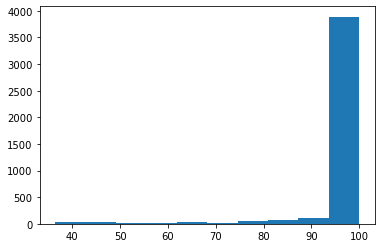

In [38]:
fig = plt.figure()
plt.hist(accruacy, bins = 10)
plt.show()

In [105]:
x

['30 - 39', '40 - 49', '50 - 59', '60 - 69', '70 - 79', '80 - 89', '99 - 100']

In [115]:
freq, _ = np.histogram(accruacy, bins=7, range=(30, 100))
x = [f'{i} - {(i+9)}' for i in range(30, 100, 10)]
x[-1] = '90 - 100'
fig = go.Figure()
fig.add_trace(go.Bar(x = x, y = freq, text= freq, textposition='auto'))
fig.update_xaxes(title='Acc')
fig.update_yaxes(title='Images')
fig.show()

In [114]:
len(accruacy)

4241

In [7]:
a, b, c, d, e = 1, 2, 3, 4, 5

In [9]:
fig = make_subplots(co)
fig.add_trace(go.Bar(x = CATEGORIES, y = [a, b, c, d], text= [a, b, c, d], textposition='auto'))
fig.update_xaxes(title='Acc')
fig.update_yaxes(title='Images')
fig.show()